In [68]:
# %% Cell 1: Import Libraries (Add new imports)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             ConfusionMatrixDisplay, RocCurveDisplay, 
                             precision_recall_curve, average_precision_score)
from sklearn.impute import SimpleImputer
from joblib import dump
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## Loading the Dataset and Info

In [35]:
# %% Cell 2: Load and Explore Dataset
# Load the latest generated dataset
data_dir = "datasets/"
latest_file = "transactions_100000_20250605_172726.csv"
df = pd.read_csv(os.path.join(data_dir, latest_file))

print(f"Dataset loaded: {latest_file}")
print(f"Shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

# Basic dataset info
print("\nDataset Info:")
df.info()

# Summary statistics
print("\nSummary Statistics:")
display(df.describe(include='all').T)

# Check class distribution
print("\nClass Distribution:")
print(df['is_fraud'].value_counts(normalize=True))

Dataset loaded: transactions_100000_20250605_172726.csv
Shape: (100000, 12)

First 5 rows:


,customer_id,timestamp,amount,old_balance,new_balance,merchant,category,location,age,gender,transaction_type,is_fraud
0,00071297,2024-11-12 05:55:34,24.09,1602.213185,1578.123185,Smith-Hogan,gaming,"West Williammouth, SG",44,M,online,0
1,00071297,2024-11-18 13:25:32,59.01,1578.123185,1519.113185,Robinson and Sons,digital_services,"Taramouth, SG",44,F,POS,0
2,00071297,2024-11-19 18:16:59,24.78,1519.113185,1494.333185,Lee Ltd,entertainment,"Baldwinland, SG",44,M,ATM,0
3,00071297,2024-11-26 12:45:51,13.98,1494.333185,1480.353185,Brown PLC,clothing,"Lake Martin, SG",44,M,POS,0
4,00071297,2024-11-28 10:37:18,11.40,1480.353185,1468.953185,"Doyle, Harrison and Wiggins",entertainment,"Teresaberg, SG",44,M,ATM,0



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   customer_id       100000 non-null  object 
 1   timestamp         100000 non-null  object 
 2   amount            100000 non-null  float64
 3   old_balance       100000 non-null  float64
 4   new_balance       100000 non-null  float64
 5   merchant          100000 non-null  object 
 6   category          100000 non-null  object 
 7   location          100000 non-null  object 
 8   age               100000 non-null  int64  
 9   gender            100000 non-null  object 
 10  transaction_type  100000 non-null  object 
 11  is_fraud          100000 non-null  int64  
dtypes: float64(3), int64(2), object(7)
memory usage: 9.2+ MB

Summary Statistics:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customer_id,100000,5000,fd83f251,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN
timestamp,100000,99857,2024-08-31 08:29:27,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amount,100000.0,NaN,NaN,NaN,49.791131,163.490765,2.73,14.65,20.84,30.0525,5541.01
old_balance,100000.0,NaN,NaN,NaN,750.560311,905.824844,-6521.886206,321.825504,737.176106,1200.15303,10296.323055
new_balance,100000.0,NaN,NaN,NaN,700.76918,920.402183,-6575.186206,268.604542,695.74882,1162.424004,10272.543055
merchant,100000,75927,Smith Group,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category,100000,12,electronics,20920,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location,100000,77252,"Port Michael, BR",17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,100000.0,NaN,NaN,NaN,46.36534,9.326696,28.0,39.0,45.0,52.0,80.0
gender,100000,2,M,50241,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Class Distribution:
is_fraud
0    0.95
1    0.05
Name: proportion, dtype: float64


In [36]:
df.dtypes

customer_id          object
timestamp            object
amount              float64
old_balance         float64
new_balance         float64
merchant             object
category             object
location             object
age                   int64
gender               object
transaction_type     object
is_fraud              int64
dtype: object

## EDA

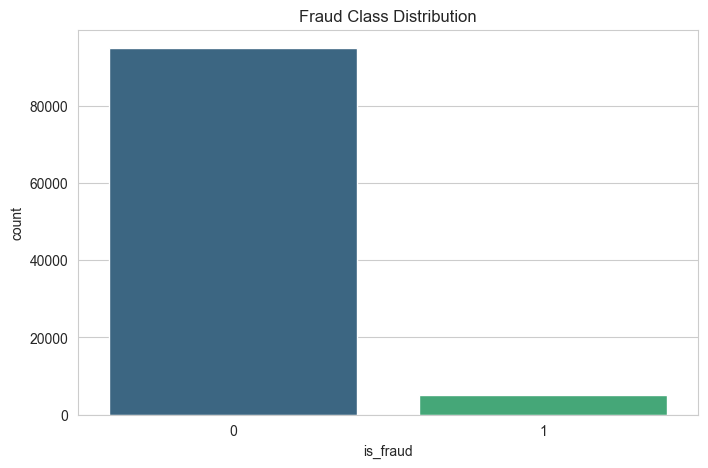

In [37]:
# 1. Target distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='is_fraud', data=df, palette='viridis')
plt.title('Fraud Class Distribution')
plt.show()

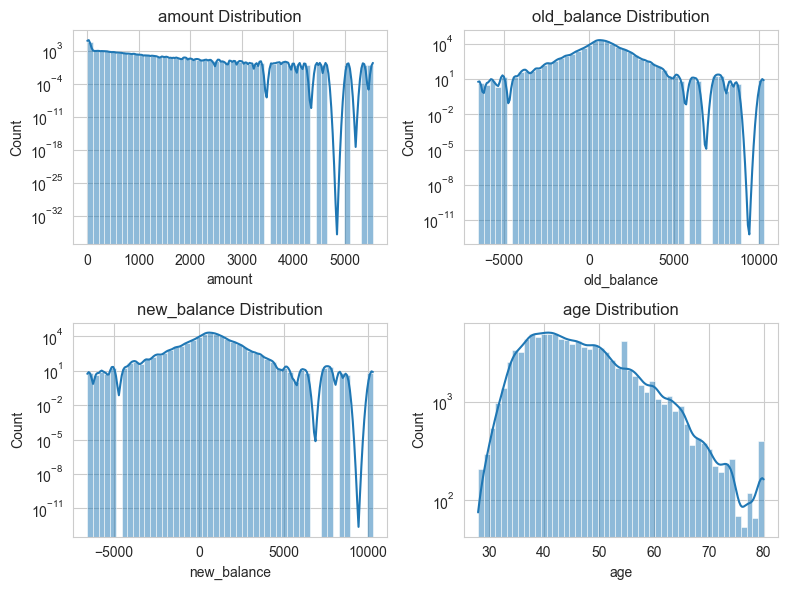

In [38]:
# 2. Numerical features distribution
num_cols = ['amount', 'old_balance', 'new_balance', 'age']
plt.figure(figsize=(8, 6))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True, bins=50)
    plt.title(f'{col} Distribution')
    plt.yscale('log')  # Log scale for better visualization
plt.tight_layout()
plt.show()

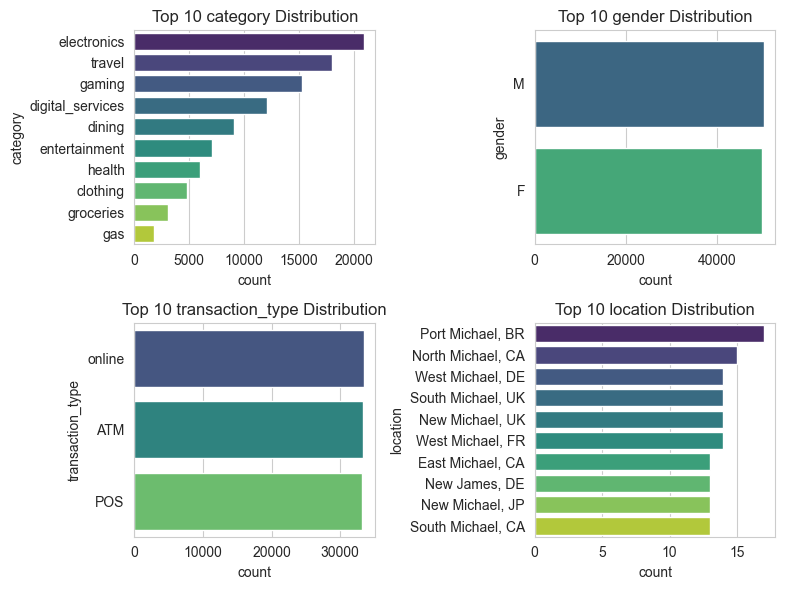

In [39]:
# 3. Categorical features analysis
cat_cols = ['category', 'gender', 'transaction_type', 'location']

plt.figure(figsize=(8, 6))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(y=col, data=df, order=df[col].value_counts().index[:10], 
                 palette='viridis')
    plt.title(f'Top 10 {col} Distribution')
plt.tight_layout()
plt.show()

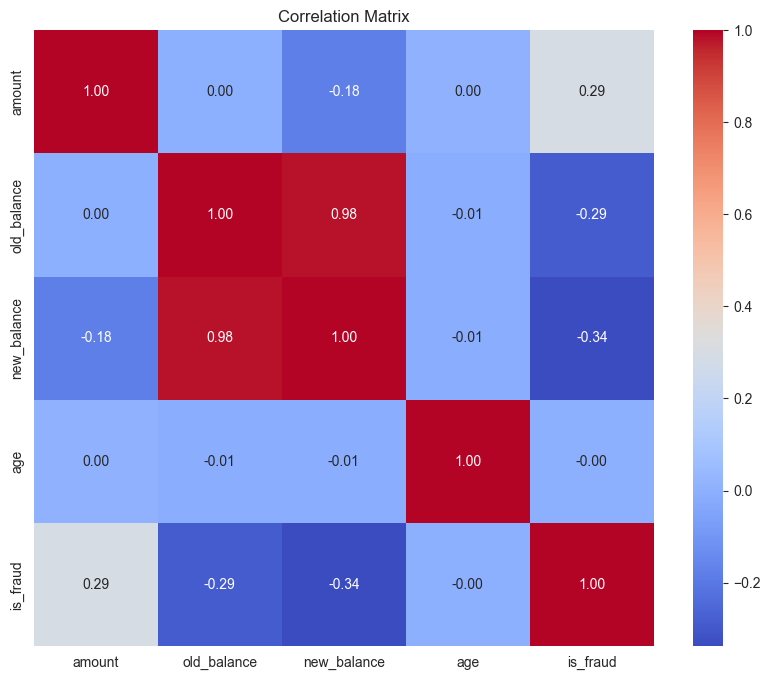

In [40]:
# 4. Correlation analysis
corr_matrix = df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

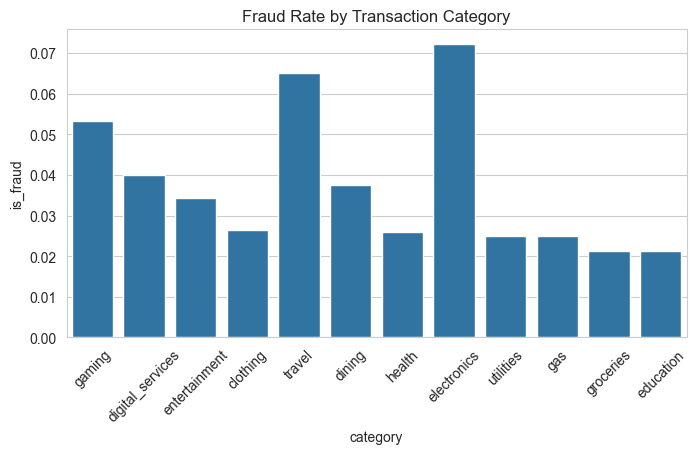

In [41]:
# 5. Fraud patterns by category
plt.figure(figsize=(8, 4))
sns.barplot(x='category', y='is_fraud', data=df, estimator=np.mean, ci=None)
plt.title('Fraud Rate by Transaction Category')
plt.xticks(rotation=45)
plt.show()

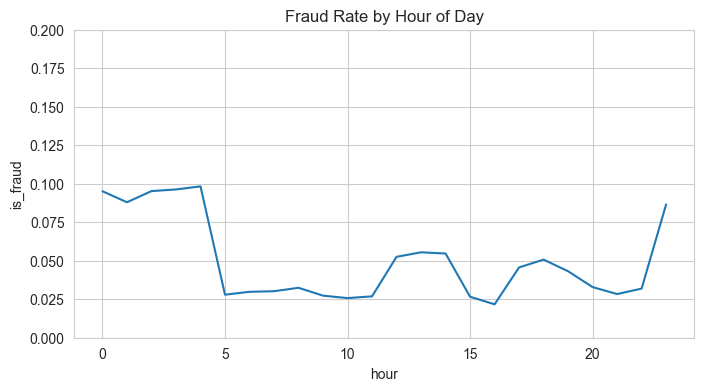

In [42]:
# 6. Time-based analysis
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
plt.figure(figsize=(8, 4))
sns.lineplot(x='hour', y='is_fraud', data=df, estimator=np.mean, ci=None)
plt.title('Fraud Rate by Hour of Day')
plt.ylim(0, 0.2)
plt.show()

## Pre-processing

In [43]:
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Feature engineering
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['balance_diff'] = df['old_balance'] - df['new_balance']
df['overdraft_attempt'] = np.where(df['amount'] > df['old_balance'], 1, 0)

In [44]:
# Define features and target
X = df.drop(['is_fraud', 'timestamp', 'customer_id', 'merchant'], axis=1)
y = df['is_fraud']

# Split data before preprocessing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [45]:
# Define preprocessing pipeline
numeric_features = ['amount', 'old_balance', 'new_balance', 'age', 'hour', 
                   'day_of_week', 'balance_diff']
categorical_features = ['category', 'location', 'gender', 'transaction_type']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

print("Preprocessing pipeline defined")

Preprocessing pipeline defined


## Training

In [55]:
# Calculate class weights for imbalance
fraud_weight = len(y_train) / (2 * np.sum(y_train))
non_fraud_weight = len(y_train) / (2 * np.sum(y_train == 0))
class_weights = {0: non_fraud_weight, 1: fraud_weight * 1.5}  # 1.5x weight for fraud

print(f"Class weights: {class_weights}")

Class weights: {0: 0.5263157894736842, 1: 15.0}


In [58]:
# Create pipeline with XGBoost (better for imbalance)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        scale_pos_weight=class_weights[1]/class_weights[0],
        objective='binary:logistic',
        eval_metric='aucpr',  # Optimize for precision-recall
        random_state=42,
        n_jobs=-1
    ))
])

In [59]:
# Hyperparameter tuning focused on precision
param_grid = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__gamma': [0, 0.1, 0.3]
}

# Use StratifiedKFold for imbalanced data
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    model, 
    param_grid, 
    cv=cv, 
    scoring='precision',  # Optimize for precision
    n_jobs=-1,
    verbose=1
)

print("Starting model training...")
grid_search.fit(X_train, y_train)

Starting model training...
Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['amount',
                                                                          'old_balance',
                                                                          'new_balance',
                                                                          'age',
                                                                          'hour',
                                                                          'day_of_week',
                                                                          'balance_diff']),
                                                                        ('cat',
                                                                         Pipeline(steps=[...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'classifier__colsample_bytree': [0.8, 1.0],
                         'classifier__gamma': [0, 0.1, 0.3],
                         'classifier__learning_rate': [0.01, 0.1],
                         'classifier__max_depth': [3, 5, 7],
                         'classifier__subsample': [0.8, 1.0]},
             scoring='precision', verbose=1)

In [60]:
# Get best model
best_model = grid_search.best_estimator_
print("\nTraining complete!")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV Precision: {grid_search.best_score_:.4f}")


Training complete!
Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__subsample': 0.8}
Best CV Precision: 0.3300


In [61]:
# %% Cell 6: Threshold Optimization
# Get predicted probabilities
y_proba = best_model.predict_proba(X_test)[:, 1]

# Find optimal threshold for precision-recall balance
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)

# Find best threshold (max F1 score)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Optimal threshold: {best_threshold:.4f} (default is 0.5)")

# Apply optimal threshold
y_pred_optimal = (y_proba >= best_threshold).astype(int)

Optimal threshold: 0.9041 (default is 0.5)


## Model Evaluation

In [63]:
# Calculate metrics with optimal threshold
accuracy = accuracy_score(y_test, y_pred_optimal)
precision = precision_score(y_test, y_pred_optimal)
recall = recall_score(y_test, y_pred_optimal)
f1 = f1_score(y_test, y_pred_optimal)
roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

# Display metrics
print("Model Evaluation Metrics (with Optimal Threshold):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}\n")

Model Evaluation Metrics (with Optimal Threshold):
Accuracy: 0.9530
Precision: 0.5234
Recall: 0.6830
F1 Score: 0.5926
ROC-AUC: 0.9663
PR-AUC: 0.6269



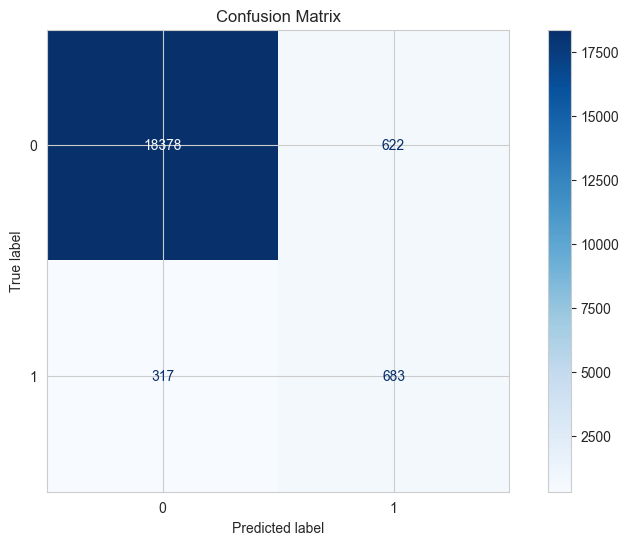

In [64]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_optimal)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

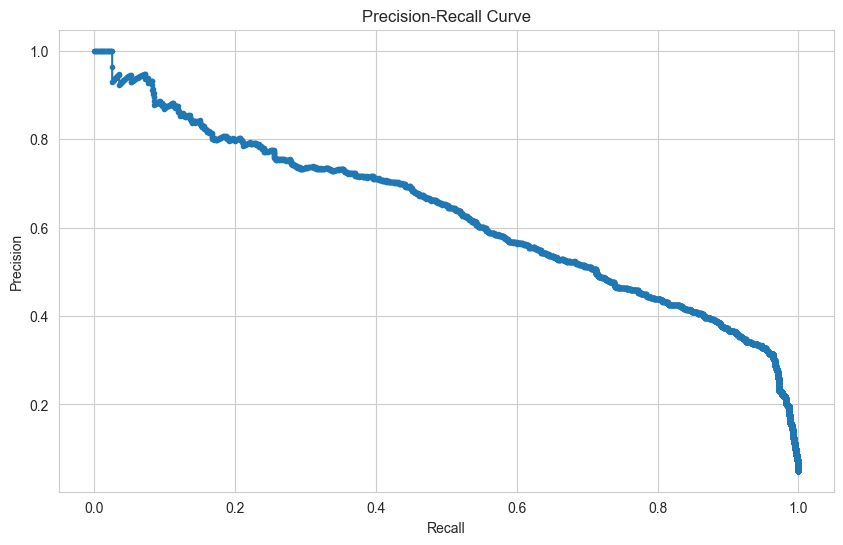

In [65]:
# Precision-Recall Curve
plt.figure(figsize=(10, 6))
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

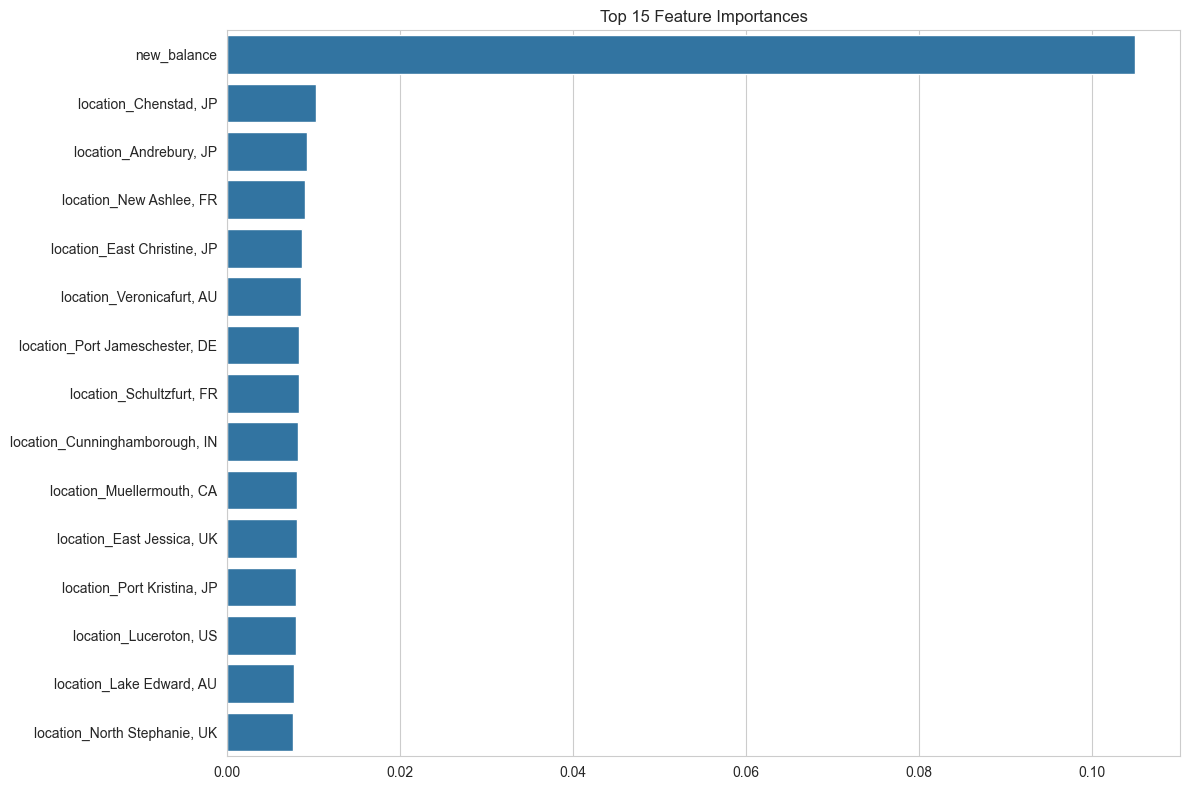

In [66]:
# Feature Importance
try:
    # For XGBoost
    feature_names = numeric_features + list(
        best_model.named_steps['preprocessor']
        .named_transformers_['cat']
        .named_steps['onehot']
        .get_feature_names_out(categorical_features)
    )
    
    importances = best_model.named_steps['classifier'].feature_importances_
    sorted_idx = importances.argsort()[::-1]
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x=importances[sorted_idx][:15], y=np.array(feature_names)[sorted_idx][:15])
    plt.title('Top 15 Feature Importances')
    plt.tight_layout()
    plt.show()
except AttributeError:
    print("Feature importance not available for this model type")

## Export Model

In [69]:
# Save the trained model
model_dir = "models/"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "fraud_detection_model_xgb.joblib")
dump(best_model, model_path)

# Save feature names for inference
feature_names_path = os.path.join(model_dir, "feature_names_xgb.json")
pd.Series(feature_names).to_json(feature_names_path)

print(f"Model saved to {model_path}")
print(f"Feature names saved to {feature_names_path}")

Model saved to models/fraud_detection_model_xgb.joblib
Feature names saved to models/feature_names_xgb.json
